##### Figure S11: linkage disequilibrium between individual variants within Vgsc, in South America, North America, and all American cohorts

In [1]:
from collections import defaultdict
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform

import allel
import seaborn as sns

import ingenos

In [2]:
base_path = "/overflow/dschridelab/users/rrlove/aedes/"
md_path = f"{base_path}metadata/"
results_path = f"{base_path}results/"
zarr_path = "/proj/dschridelab/rrlove/aedes/vcf/filtered_110122/"

In [3]:
def return_data(zarr_path, data_type, data_name):
    
    fetch_str = f"{data_type}/{data_name}" 
    
    return da.from_zarr(zarr_path, component=fetch_str)

##### read in the data

In [4]:
chroms_dict = defaultdict(dict)

for chrom in ["AaegL5_3"]:
    
    temp_in_path = zarr_path + chrom

    chroms_dict[chrom]["pos"] = return_data(temp_in_path, "variants", "POS")
    chroms_dict[chrom]["chrom"] = return_data(temp_in_path, "variants", "CHROM")
    chroms_dict[chrom]["ref"] = return_data(temp_in_path, "variants", "REF")
    chroms_dict[chrom]["alt"] = return_data(temp_in_path, "variants", "ALT")
    chroms_dict[chrom]["ac"] = return_data(temp_in_path, "variants", "AC")
    chroms_dict[chrom]["qd"] = return_data(temp_in_path, "variants", "QD")
    chroms_dict[chrom]["mq"] = return_data(temp_in_path, "variants", "MQ")
    chroms_dict[chrom]["fs"] = return_data(temp_in_path, "variants", "FS")
    chroms_dict[chrom]["mqrs"] = return_data(temp_in_path, "variants", "MQRankSum")
    chroms_dict[chrom]["rprs"] = return_data(temp_in_path, "variants", "ReadPosRankSum")
    chroms_dict[chrom]["sor"] = return_data(temp_in_path, "variants", "SOR")
    chroms_dict[chrom]["is_snp"] = return_data(temp_in_path, "variants", "is_snp")
    chroms_dict[chrom]["numalt"] = return_data(temp_in_path, "variants", "numalt")
    chroms_dict[chrom]["filter_pass"] = return_data(temp_in_path, "variants", "FILTER_PASS")

    chroms_dict[chrom]["gt"] = return_data(temp_in_path, "calldata", "GT")
    chroms_dict[chrom]["gq"] = return_data(temp_in_path, "calldata", "GQ")
    chroms_dict[chrom]["ad"] = return_data(temp_in_path, "calldata", "AD")
    chroms_dict[chrom]["pl"] = return_data(temp_in_path, "calldata", "PL")
    chroms_dict[chrom]["dp"] = return_data(temp_in_path, "calldata", "DP")
    
    print(chrom, chroms_dict[chrom]["gt"].shape)
    
samples = da.from_zarr(temp_in_path, component="samples")

AaegL5_3 (27660249, 131, 2)


##### load the metadata

In [5]:
md = pd.read_table(
    md_path + "whole_sample_sorted_country.031522.csv", 
    sep="\t",)

md["locality"] = md["location"].str.split(": ", expand=True)[1]

md.head()

,sample_id,sample_short,location,sex,batch,sample_id_cat,country,locality
0,FEMALE_1-F1_CGCATGAT-TCAGGCTT_S1,FEMALE_1,Colombia: Rio Claro,F,1,FEMALE_1-F1_CGCATGAT-TCAGGCTT_S1,Colombia,Rio Claro
1,FEMALE_10-F10_GTGCCATA-ACTAGGAG_S2,FEMALE_10,Colombia: Rio Claro,F,1,FEMALE_10-F10_GTGCCATA-ACTAGGAG_S2,Colombia,Rio Claro
2,FEMALE_11-F11_CGTTGCAA-CGCTCTAT_S3,FEMALE_11,Colombia: Rio Claro,F,1,FEMALE_11-F11_CGTTGCAA-CGCTCTAT_S3,Colombia,Rio Claro
3,FEMALE_12-F12_TGAAGACG-TGGCATGT_S4,FEMALE_12,Colombia: Rio Claro,F,1,FEMALE_12-F12_TGAAGACG-TGGCATGT_S4,Colombia,Rio Claro
4,FEMALE_14-F14_ACGTTCAG-GCACAACT_S6,FEMALE_14,Colombia: Rio Claro,F,1,FEMALE_14-F14_ACGTTCAG-GCACAACT_S6,Colombia,Rio Claro


In [6]:
np.sum(~(md["sample_id"] == samples.compute()))

0

##### specimens to drop

In [7]:
to_drop = np.loadtxt(md_path + "close_kin_removed_new_dataset.txt",
                    dtype=str)

to_drop_bool = (~(md["sample_short"].isin(to_drop)).values)

np.sum(to_drop_bool)

123

In [8]:
to_drop

array(['SRR11006849', 'SRR11006846', 'SRR6768018', 'FEMALE_17',
       'FEMALE_22', 'SRR11006674', 'SRR11006683', 'SRR11006754'],
      dtype='<U11')

In [9]:
md_filtered = md.loc[to_drop_bool]

md_filtered.reset_index(drop=True, inplace=True)

md_filtered.shape

(123, 8)

##### read in locations of repetitive regions/regions that don't map uniquely

In [10]:
mask = pd.read_table(
    f"{base_path}refs/aegy/unified_mask/merged_rep_map_masks.110822.bed",
sep="\t", names=["chrom", "start", "end"])

mask.head()

,chrom,start,end
0,AaegL5_1,0,273
1,AaegL5_1,297,373
2,AaegL5_1,413,7449
3,AaegL5_1,7452,8789
4,AaegL5_1,9854,18833


##### narrow to Vgsc

In [11]:
vgsc_bounds = (315926360, 316405639)

region_flt = ((chroms_dict[chrom]["pos"] > vgsc_bounds[0]) & \
            (chroms_dict[chrom]["pos"] < vgsc_bounds[1]))

np.sum(region_flt).compute()

33298

In [12]:
vgsc_pos = chroms_dict[chrom]["pos"][region_flt].compute()

vgsc_pos.shape

(33298,)

##### set up population and continent filters

In [13]:
country_bools = {}

for country in md["country"].unique():
    
    country_bools[country] = (md_filtered["country"] == country).values

In [14]:
continent_bools = {}

continent_bools["South_America"] =\
((md["country"] == "Brazil") | (md_filtered["country"] == "Colombia")).values

continent_bools["North_America"] = (md_filtered["country"] == "USA").values

continent_bools["Americas"] = ((md_filtered["country"] == "Brazil") | \
                               (md_filtered["country"] == "Colombia") | \
                               (md_filtered["country"] == "USA"))

In [15]:
gt = \
allel.GenotypeArray(chroms_dict[chrom]["gt"]).subset(
    sel0 = region_flt, sel1 = to_drop_bool)

gt.shape

(33298, 123, 2)

In [16]:
gq = chroms_dict[chrom]["gq"][region_flt, :][:, to_drop_bool].compute()

gq.shape

(33298, 123)

In [17]:
gt.mask = (gq < 20)

In [18]:
continent_ld_dict = {}

for pop, pop_flt in continent_bools.items():
    
    pop_gt = gt.subset(sel1 = pop_flt)
    
    is_seg = pop_gt.count_alleles().is_variant()
    
    pop_gt = pop_gt.subset(sel0 = is_seg)
    
    print(pop, np.sum(is_seg))
    
    pop_alts = pop_gt.to_n_alt()
    
    pop_vssc_ld = allel.rogers_huff_r(pop_alts)
    
    pop_pos = vgsc_pos[is_seg]
        
    continent_ld_dict[pop] = (pop_vssc_ld, pop_pos)
    

South_America 7330
North_America 6219
Americas 8564


In [19]:
names_dict = {"North_America" : "North America",
             "South_America" : "South America",
             "Americas" : "The Americas"}

In [20]:
outstring = ingenos.make_date_stamp(
    results_path + "Vssc/Vssc_Americas_LD", 
    ".png")

outstring

'/overflow/dschridelab/users/rrlove/aedes/results/Vssc/Vssc_Americas_LD.021023.png'

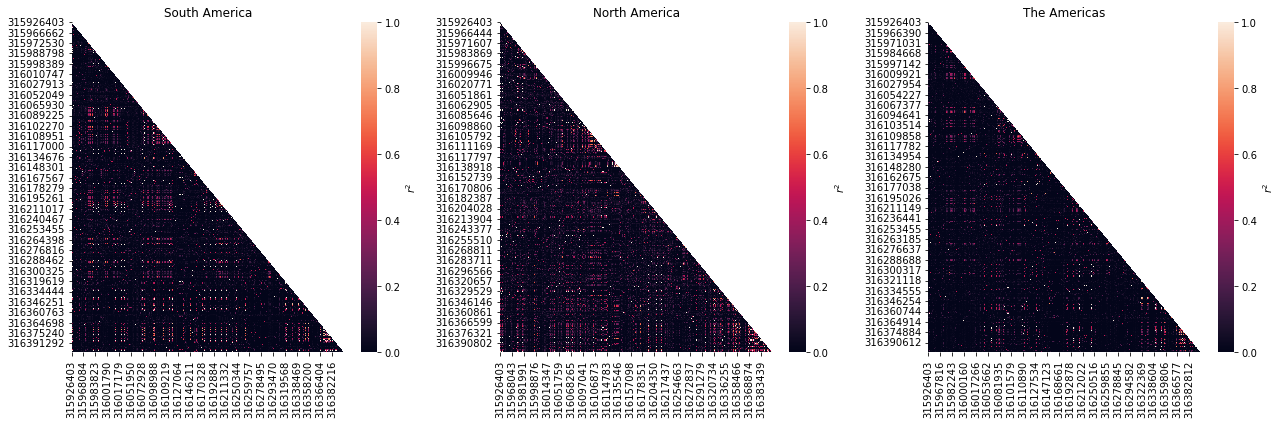

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

for i, (pop_name, (pop_ld, pop_pos)) in enumerate(continent_ld_dict.items()):
    
    ax = axes.flatten()[i]
    
    pop_ld_mat_df = pd.DataFrame(squareform(pop_ld ** 2), columns=pop_pos, index=pop_pos)
    
    mask = np.zeros_like(pop_ld_mat_df)

    mask[np.triu_indices_from(mask)] = True
    
    sns.heatmap(pop_ld_mat_df, ax=ax, mask=mask)

    ax.set_title(names_dict[pop_name])

    ax.collections[0].colorbar.set_label("$r^2$")
    
plt.tight_layout()

#plt.savefig(outstring, facecolor="white", dpi=200, 
#            bbox_inches="tight")